# 1.Fig2

## 1.1 gene&peaks correlation

*Read DEGs Result*

In [3]:
DEG_RNA <- openxlsx::read.xlsx("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/Bulk_RNA_output/Tilapia_ColdvsCtrl_DEG_RNA.xlsx")

In [6]:
max(DEG_RNA$padj)

[1] 0.04999837

In [638]:
DEG_RNA.genes <- DEG_RNA %>% filter(tissue != "SP") %>% .$gene %>% unique

*Read peaks counts*

In [ ]:
bulk_atac <- dba(sampleSheet = "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/sample_info_rep.csv", minOverlap = 3)
atac_df <- read.csv("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/sample_info_rep.csv")
head(atac_df,2)

bulk_atac_counts <- dba.count(bulk_atac,score=DBA_SCORE_TMM_READS_EFFECTIVE_CPM,bUseSummarizeOverlaps = TRUE,bParallel=TRUE)

temp <- as.data.frame(bulk_atac_counts$peaks)
RPKM <- temp[,grep(colnames(temp),pattern = "^RPKM|Chr$|Start$|End$")]
rm(temp)

In [861]:
colnames(RPKM)[4:15] <- bulk_atac_counts$samples$SampleID
RPKM <- RPKM[,grep(colnames(RPKM),pattern = "SP",invert = T)] %>% tibble::rownames_to_column(var = "peak_id")

*peaks anno*

In [701]:
library(plyranges,include.only = c("as_granges","join_overlap_inner"))

In [863]:
RPKM_gr <- RPKM %>% dplyr::rename(seqnames = "Chr" , start = "Start",end = "End") %>% as_granges()

In [864]:
RPKM_gr_anno <- suppressWarnings(ChIPseeker::annotatePeak(peak = RPKM_gr,
                       TxDb = spompe, 
                       tssRegion = c(-3000, 500), 
                       addFlankGeneInfo = FALSE))
RPKM_gr_anno <- as.data.frame(RPKM_gr_anno)

>> preparing features information...		 2024-03-07 08:07:35 PM 
>> identifying nearest features...		 2024-03-07 08:07:35 PM 
>> calculating distance from peak to TSS...	 2024-03-07 08:07:39 PM 
>> assigning genomic annotation...		 2024-03-07 08:07:39 PM 
>> assigning chromosome lengths			 2024-03-07 08:07:42 PM 
>> done...					 2024-03-07 08:07:42 PM 


In [866]:
RPKM_gr_anno$group <- "Distal"
RPKM_gr_anno$group[grep(RPKM_gr_anno$annotation,pattern = "^Promoter")] <- "Promoter"
RPKM_gr_anno$group[grep(RPKM_gr_anno$annotation,pattern = "^3' UTR|5' UTR")]  <- "Genic"
RPKM_gr_anno$group[grep(RPKM_gr_anno$annotation,pattern = "^Exon|Intron")] <- "Genic"

RPKM_gr_anno_filter <- RPKM_gr_anno[RPKM_gr_anno$group != "Distal",]

In [796]:
scale_row <- function(x){
    m = apply(x, 1, mean, na.rm = T)
    s = apply(x, 1, sd, na.rm = T)
    return((x - m) / s)
}

*DEG.ATAC results from Fig1 DIffbind for identifying differential peaks.*

In [882]:
DEG.ATAC2 <- DEG.ATAC %>% filter(tissue != "SP") %>% na.omit

In [887]:
temp <- RPKM_gr_anno_filter[,c(1:3,6,15,21,24)] %>% left_join(DEG.ATAC2[,c(2,5,6,7,8)],by = c("peak_id"="gene"))

In [909]:
DEG_RNA_select <- DEG_RNA %>% filter(tissue != "SP",padj < 0.05) %>% dplyr::select(2,5,6,7,8)
colnames(DEG_RNA_select) <- paste("RNA",colnames(DEG_RNA_select),sep = "_")

In [913]:
RNA_ATAC_cor <- DEG_RNA_select %>% left_join(temp,by = c("RNA_gene" = "geneId","RNA_tissue" = "tissue"))

Warning message in left_join(., temp, by = c(RNA_gene = "geneId", RNA_tissue = "tissue")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 2 of `x` matches multiple rows in `y`.
ℹ Row 158371 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning."


In [915]:
RNA_ATAC_cor$log2FoldChange[is.na(RNA_ATAC_cor$log2FoldChange)] <- 0
RNA_ATAC_cor$cor <- RNA_ATAC_cor$RNA_log2FoldChange * RNA_ATAC_cor$log2FoldChange

In [925]:
RNA_ATAC_cor_anno <- RNA_ATAC_cor %>% left_join(geneID_name,by = c("RNA_gene" = "gene"))

Warning message in left_join(., geneID_name, by = c(RNA_gene = "gene")):
"Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 435 of `x` matches multiple rows in `y`.
ℹ Row 28317 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship = "many-to-many"` to silence this warning."


In [940]:
openxlsx::write.xlsx(list(HK = RNA_ATAC_cor_anno %>% filter(RNA_tissue == "HK"),
                           TH = RNA_ATAC_cor_anno %>% filter(RNA_tissue == "TH")),
                "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/RNA&ATAC_output/20240307_RNA_DEGs_ATAC_cor.xlsx")

## 1.2 subset Heatmap

*TPM is derived from the upstream analysis of RNA data using the TPMCalculator output file.*
<br>/home/zhangdeyin/cjb/jiaohe/0.RNA/RNA-Seq_tpm_countstable.xls

In [1095]:
TPM <- read.delim("/home/zhangdeyin/cjb/jiaohe/0.RNA/RNA-Seq_tpm_countstable.xls",sep = "\t")
TPM <- TPM[,grep(colnames(TPM),pattern = "SP",invert = T)]

In [1004]:
library(ComplexHeatmap)

In [1018]:
vst.heatmap <- readRDS("/home/minghao/workbase_jinagbo/vst.heatmap2c.rds")

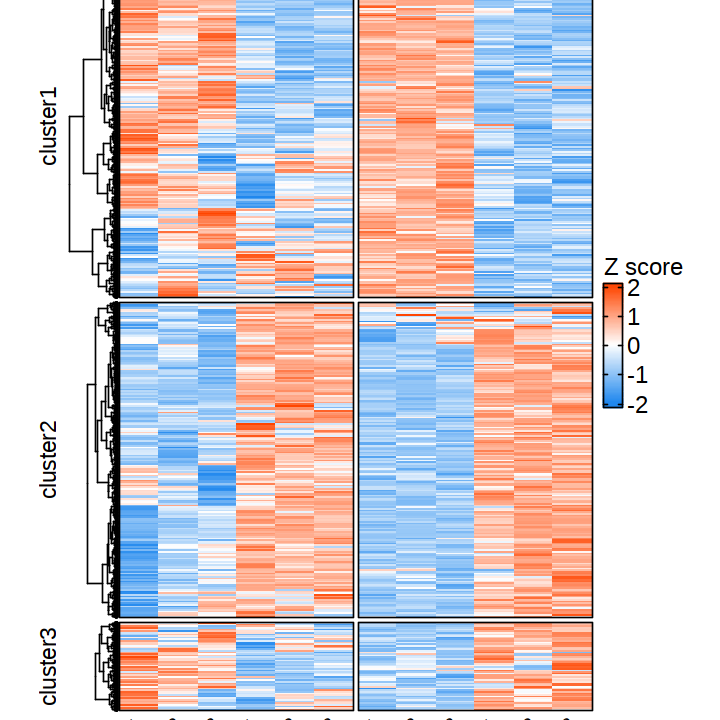

In [1034]:
options(repr.plot.width = 6,repr.plot.height = 6)
vst.heatmap

*从RNA_ATAC_cor_anno中获取DEG > 1的DEGs以及cor > 0的基因及peak*

In [1063]:
cluster_gene <- openxlsx::read.xlsx("/home/minghao/workbase_jinagbo/Heatmap_clustergenes.xlsx")

In [1084]:
cluster_gene2 <- unique(cluster_gene[,1:2])

In [1099]:
pre_heatmap_gene <- RNA_ATAC_cor_anno[!is.na(RNA_ATAC_cor_anno$peak_id),] %>% 
    filter(cor > 0) %>% .$RNA_gene %>% unique

In [1124]:
cor_gene_TPM <- TPM[TPM$Gene_Id %in% pre_heatmap_gene,]
indexs <- apply(cor_gene_TPM[,2:13],1,max) > 1
heatmap_gene <- cor_gene_TPM[indexs,"Gene_Id"]

In [1132]:
RNA_ATAC_cor_anno_filter <- RNA_ATAC_cor_anno[RNA_ATAC_cor_anno$RNA_gene %in% heatmap_gene,] %>% 
    filter(cor > 0)
RNA_ATAC_cor_anno_filter <- RNA_ATAC_cor_anno_filter[!is.na(RNA_ATAC_cor_anno_filter$peak_id),]

In [1141]:
heatmap_gene2 <- unique(RNA_ATAC_cor_anno_filter$RNA_gene)

In [1144]:
head(heatmap_gene2,2)

[1] "ENSONIG00000042238" "ENSONIG00000019199"

In [1226]:
heatmap_gene2_cluster <- cluster_gene2[cluster_gene2$gene %in% heatmap_gene2,]
#cluster_gene2为Fig1 热图的gene，heatmap_gene2为TPM > 1,cor > 1的基因

In [1266]:
setdiff(heatmap_gene2 , cluster_gene2$gene)

[1] "ENSONIG00000033462" "ENSONIG00000007340" "ENSONIG00000021389"

In [1204]:
head(heatmap_gene2_cluster,2)

,cluster,gene
,<chr>,<chr>
1,3,ENSONIG00000034346
2,3,ENSONIG00000019895


*Plot Heatmap*

In [1172]:
#读取热图表达矩阵
temp <- readRDS("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/Bulk_RNA_output/20240308_ZMH_Fig1_Heatmap_matrix.rds")

Heatmap_data <- temp[heatmap_gene2_cluster$gene,]

In [1185]:
table(heatmap_gene2_cluster$cluster)


   1    2    3 
1499 2835  635 

In [1227]:
heatmap_gene2_cluster$cluster <- factor(heatmap_gene2_cluster$cluster,levels = c("1","2","3"),
                                        labels = c("cluster1\n(1499 41%)","cluster2\n(2835 85%)","cluster3\n(635 68%)"))

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.



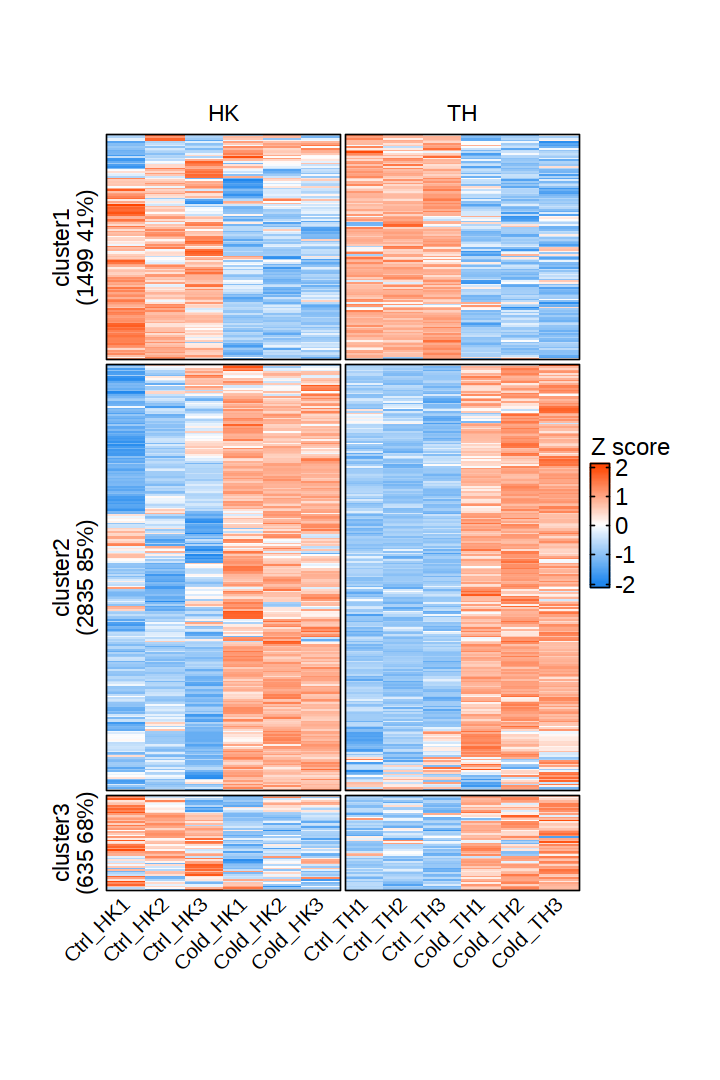

In [1228]:
options(repr.plot.width = 6,repr.plot.height = 9)
Fig2_Heatmap <- Heatmap(Heatmap_data,cluster_rows = FALSE,
        row_order = match(rownames(Heatmap_data),rev(heatmap_gene2_cluster$gene) ),
        cluster_row_slices = FALSE,
        col = colorRampPalette(c("#1C86EE","white","#FF4500"))(100),
        cluster_columns = F,   
        clustering_distance_rows = function(m) dist(m),
        clustering_method_rows = "ward.D2",
        #row_km = 5,
        use_raster = TRUE,
        border = TRUE,
        row_split = heatmap_gene2_cluster$cluster,
        column_split = factor( rep(c("HK","TH"), each = 6)),
        heatmap_legend_param = list(
             title='Z score',
             title_gp = gpar(fontsize = 14),
             labels_gp = gpar(fontsize = 14),
             border='black'),
        show_row_names = FALSE,
        width = unit(10, "cm"),
        height = unit(16, "cm"),
         show_column_dend = FALSE,
        column_names_rot = 45)
Fig2_Heatmap2 <- draw(Fig2_Heatmap)

In [1229]:
pdf("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/plot/Fig2_Heatmap.pdf", 
    width = 6, height = 8)
Fig2_Heatmap2
dev.off()

png 
  2

## 1.3 Deeptools ATAC Heatmap

1.TSS信号值

In [1293]:
tss_df <- read.delim("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Genome/Nile_Tilapia_TSS_109_Ensembl.txt",sep = "\t")

tss_df <- tss_df %>% dplyr::select(1,2,5) %>% unique %>% 
    dplyr::rename(gene = "Gene.stable.ID",tss_start = "Transcription.start.site..TSS.",LG = "Chromosome.scaffold.name")
tss_df$tss_end <- tss_df$tss_start + 1

In [1309]:
lapply(split(heatmap_gene2_cluster$gene,heatmap_gene2_cluster$cluster),function(x){
    tss <- tss_df[tss_df$gene %in% x,2:4]
    
}) -> tss_list

In [1310]:
setwd("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/RNA&ATAC_output")
write.table(tss_list[[1]],"./20240308_cluster1.bed",sep = "\t",col.names = F,row.names = F,quote = F)
write.table(tss_list[[2]],"./20240308_cluster2.bed",sep = "\t",col.names = F,row.names = F,quote = F)
write.table(tss_list[[3]],"./20240308_cluster3.bed",sep = "\t",col.names = F,row.names = F,quote = F)

2.peaks信号值

In [1590]:
RNA_ATAC_cor_anno_filter %>% 
        inner_join(heatmap_gene2_cluster,by = c("RNA_gene" = "gene")) %>% filter() %>% 
    dplyr::select(1,6:8,19,5) %>% distinct %>% split(.$cluster) -> temp

In [1591]:
temp[[1]] <- temp[[1]][temp[[1]]$RNA_log2FoldChange < 0,]

In [1596]:
setwd("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/RNA&ATAC_output")
write.table(temp[[1]][,2:4],"./20240308_cluster1.bed",sep = "\t",col.names = F,row.names = F,quote = F)
write.table(temp[[2]][,2:4],"./20240308_cluster2.bed",sep = "\t",col.names = F,row.names = F,quote = F)
write.table(temp[[3]][,2:4],"./20240308_cluster3.bed",sep = "\t",col.names = F,row.names = F,quote = F)

In [1594]:
subset_heatmap_peaks <- temp

In [1605]:
setwd("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/RNA&ATAC_output")
write.table(rbind(subset_heatmap_peaks[[1]][,2:4],subset_heatmap_peaks[[2]][,2:4],subset_heatmap_peaks[[3]][,2:4]),
           "./20240308_cluster_merge.bed",sep = "\t",col.names = F,row.names = F,quote = F)

```shell
#cd /home/zhangdeyin/cjb/jiaohe/minhaobam/merge

cd ~/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/rmDuplicates
sample=("Ctrl_HK" "Cold_HK" "Ctrl_TH" "Cold_TH")
output=/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/bw/merge_bw_bySizeFactor

declare -A scaleFactorMap
scaleFactorMap["Ctrl_HK"]=0.511042094572749 #DEseq2 重复间的sizefactor相加后取倒数
scaleFactorMap["Cold_HK"]=0.476776451026529
scaleFactorMap["Ctrl_TH"]=0.526980833122425
scaleFactorMap["Cold_TH"]=0.464729807670357

for id in ${sample[@]}; do
  echo ${id}
  ######samtools index -@ 5 ${id}.rmdup.bam##
  scaleFactor=${scaleFactorMap[${id}]}
  bamCoverage -b ${id}.rmdup.merge.bam -o ${output}/${id}_merge.bw --binSize 50 --scaleFactor ${scaleFactor} --numberOfProcessors 40
done 

```

```shell
##20240308
#cluster1
cd /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/RNA&ATAC_output
computeMatrix reference-point --missingDataAsZero --referencePoint TSS \
-b 2000 -a 2000 \
-S /home/zhangdeyin/cjb/jiaohe/minhaobam/merge/bw/Ctrl_HK_merge.bw /home/zhangdeyin/cjb/jiaohe/minhaobam/merge/bw/Cold_HK_merge.bw /home/zhangdeyin/cjb/jiaohe/minhaobam/merge/bw/Ctrl_TH_merge.bw /home/zhangdeyin/cjb/jiaohe/minhaobam/merge/bw/Cold_TH_merge.bw \
-p 50 \
-R 20240308_cluster1.bed  \
--skipZeros \
-o /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/deeptools_output/20240308_Fig2_scale_regions_ATAC_clustergene.mat.gz \
--outFileSortedRegions /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/deeptools_output/20240308_Fig2_scale_regions_ATAC_clustergene.bed

plotHeatmap -m /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/deeptools_output/20240308_Fig2_scale_regions_ATAC_clustergene.mat.gz \
     -out /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/deeptools_output/20240308_Fig2_cluster1_Heatmap.pdf \
     --colorMap YlGnBu
#cluter2     
computeMatrix reference-point --missingDataAsZero --referencePoint TSS \
-b 2000 -a 2000 \
-S /home/zhangdeyin/cjb/jiaohe/minhaobam/merge/bw/Ctrl_HK_merge.bw /home/zhangdeyin/cjb/jiaohe/minhaobam/merge/bw/Cold_HK_merge.bw /home/zhangdeyin/cjb/jiaohe/minhaobam/merge/bw/Ctrl_TH_merge.bw /home/zhangdeyin/cjb/jiaohe/minhaobam/merge/bw/Cold_TH_merge.bw \
-p 50 \
-R 20240308_cluster2.bed  \
--skipZeros \
-o /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/deeptools_output/20240308_Fig2_scale_regions_ATAC_clustergene.mat.gz \
--outFileSortedRegions /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/deeptools_output/20240308_Fig2_scale_regions_ATAC_clustergene.bed

plotHeatmap -m /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/deeptools_output/20240308_Fig2_scale_regions_ATAC_clustergene.mat.gz \
     -out /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/deeptools_output/20240308_Fig2_cluster2_Heatmap.pdf \
     --colorMap YlGnBu
#cluster3    
computeMatrix reference-point --missingDataAsZero --referencePoint TSS \
-b 2000 -a 2000 \
-S /home/zhangdeyin/cjb/jiaohe/minhaobam/merge/bw/Ctrl_HK_merge.bw /home/zhangdeyin/cjb/jiaohe/minhaobam/merge/bw/Cold_HK_merge.bw /home/zhangdeyin/cjb/jiaohe/minhaobam/merge/bw/Ctrl_TH_merge.bw /home/zhangdeyin/cjb/jiaohe/minhaobam/merge/bw/Cold_TH_merge.bw \
-p 50 \
-R 20240308_cluster3.bed  \
--skipZeros \
-o /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/deeptools_output/20240308_Fig2_scale_regions_ATAC_clustergene.mat.gz \
--outFileSortedRegions /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/deeptools_output/20240308_Fig2_scale_regions_ATAC_clustergene.bed

plotHeatmap -m /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/deeptools_output/20240308_Fig2_scale_regions_ATAC_clustergene.mat.gz \
     -out /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/deeptools_output/20240308_Fig2_cluster3_Heatmap.pdf \
     --colorMap YlGnBu     



```

In [1598]:
lapply(subset_heatmap_peaks,nrow)
temp <- RNA_ATAC_cor_anno %>% inner_join(heatmap_gene2_cluster,by = c("RNA_gene"="gene")) %>% dplyr::select(RNA_gene,RNA_tissue,cluster,cor,peak_id)
temp <- na.omit(temp) %>% distinct
temp <- temp %>% distinct(peak_id,.keep_all = T) %>% unique
table(heatmap_gene2_cluster$cluster)
table(temp$cluster)

$`cluster1\n(1499 41%)`
[1] 4257

$`cluster2\n(2835 85%)`
[1] 11659

$`cluster3\n(635 68%)`
[1] 1674


cluster1\n(1499 41%) cluster2\n(2835 85%)  cluster3\n(635 68%) 
                1499                 2835                  635 


cluster1\n(1499 41%) cluster2\n(2835 85%)  cluster3\n(635 68%) 
                8937                13866                 2479 

In [1604]:
4257/8937
11659/13866
1674/2479
4257 + 11659 + 1674

[1] 0.4763343

[1] 0.8408337

[1] 0.6752723

[1] 17590

In [2619]:
lapply(subset_heatmap_peaks,dim)

$`cluster1\n(1499 41%)`
[1] 4257    6

$`cluster2\n(2835 85%)`
[1] 11659     6

$`cluster3\n(635 68%)`
[1] 1674    6

## Motif Enrich

In [1400]:
subset_heatmap_peaks[[1]] %>% head(2)

,RNA_log2FoldChange,seqnames,start,end,cluster,RNA_tissue
,<dbl>,<fct>,<int>,<int>,<fct>,<chr>
9028,-0.3146412,LG15,2024548,2024948,cluster1 (1499 41%),HK
9029,-0.3146412,LG15,2024548,2024948,cluster1 (1499 41%),HK


In [1396]:
lapply(1:length(subset_heatmap_peaks),function(x){
    data <- subset_heatmap_peaks[[x]]
    write.table(data[,2:4],paste0("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster",x,".bed"),
            sep = "\t",quote = F,col.names = F,row.names = F)
})

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

In [1514]:
lapply(1:length(subset_heatmap_peaks),function(x){
    data <- subset_heatmap_peaks[[x]]
    data_HK <- data %>% filter(RNA_tissue == "HK")
    data_SP <- data %>% filter(RNA_tissue == "TH")
    write.table(data_HK[,2:4],paste0("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster",x,"_HK.bed"),
            sep = "\t",quote = F,col.names = F,row.names = F)
    write.table(data_SP[,2:4],paste0("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster",x,"_TH.bed"),
            sep = "\t",quote = F,col.names = F,row.names = F)
})

[[1]]
NULL

[[2]]
NULL

[[3]]
NULL

```shell

mkdir -p /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input
genome=/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Genome/Oreochromis_niloticus.O_niloticus_UMD_NMBU.dna.109.fa
cd /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input

find ./ -regex ".*[0-9]\.bed" | while read id;do
name=$(basename ${id})
name=${name/.bed/}
echo ${id} ${name}
findMotifsGenome.pl ${id} ${genome} ${name}_homer_motif_output -p 60
done

```

```shell

find ./ -regex ".*[A-Z][A-Z]\.bed" | while read id; do
name=$(basename ${id})
name=${name/.bed/}
echo ${id} ${name}
findMotifsGenome.pl ${id} ${genome} ${name}_homer_motif_output -p 60
done


findMotifsGenome.pl /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster1_TH.bed \
/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Genome/Oreochromis_niloticus.O_niloticus_UMD_NMBU.dna.109.fa \
/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster1_TH_homer_motif_output -p 60

findMotifsGenome.pl /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster2_TH.bed \
/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Genome/Oreochromis_niloticus.O_niloticus_UMD_NMBU.dna.109.fa \
/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster2_TH_homer_motif_output -p 60

findMotifsGenome.pl /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster3_TH.bed \
/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Genome/Oreochromis_niloticus.O_niloticus_UMD_NMBU.dna.109.fa \
/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster3_TH_homer_motif_output -p 60

```

In [1515]:
setwd("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input")
homer_res_path_dir <- list.files(path = "./",pattern = "cluster[1-9]_HK_homer_motif_output",include.dirs = TRUE)

In [1525]:
lapply(homer_res_path_dir,function(x){
    path <- list.files(path = paste0("./",x),pattern = "knownResults.txt",full.names = T)
    print(path)
    temp <- read.delim(path,header = T,sep = "\t") %>% filter(q.value..Benjamini. < 0.05)
    return(temp)
}) -> HK_homer_res

[1] "./DEPeaks_cluster1_HK_homer_motif_output/knownResults.txt"
[1] "./DEPeaks_cluster2_HK_homer_motif_output/knownResults.txt"
[1] "./DEPeaks_cluster3_HK_homer_motif_output/knownResults.txt"


In [1528]:
openxlsx::write.xlsx(x = list("Cluster1" = HK_homer_res[[1]],"Cluster2" = HK_homer_res[[2]],"Cluster3" = HK_homer_res[[3]]),
                     file = "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/output/HK_homer_res.xlsx")

In [1529]:
setwd("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input")
homer_res_path_dir <- list.files(path = "./",pattern = "cluster[1-9]_TH_homer_motif_output",include.dirs = TRUE)

In [1531]:
lapply(homer_res_path_dir,function(x){
    path <- list.files(path = paste0("./",x),pattern = "knownResults.txt",full.names = T)
    print(path)
    temp <- read.delim(path,header = T,sep = "\t") %>% filter(q.value..Benjamini. < 0.05)
    return(temp)
}) -> TH_homer_res

[1] "./DEPeaks_cluster1_TH_homer_motif_output/knownResults.txt"
[1] "./DEPeaks_cluster2_TH_homer_motif_output/knownResults.txt"
[1] "./DEPeaks_cluster3_TH_homer_motif_output/knownResults.txt"


In [1532]:
openxlsx::write.xlsx(x = list("Cluster1" = TH_homer_res[[1]],"Cluster2" = TH_homer_res[[2]],"Cluster3" = TH_homer_res[[3]]),
                     file = "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/output/TH_homer_res.xlsx")

```shell
cd /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster1_HK_homer_motif_output/knownResults/
cat known3.motif known9.motif known20.motif known27.motif > merge_4.motif

annotatePeaks.pl /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster1_HK.bed \
/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Genome/Oreochromis_niloticus.O_niloticus_UMD_NMBU.dna.109.fa \
-m merge_4.motif > DEPeaks_cluster1_HK_merge_4_motif.txt

```

```shell
cd /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster2_HK_homer_motif_output/knownResults
cat known1.motif known67.motif known89.motif known147.motif known99.motif known100.motif known117.motif \
/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster1_HK_homer_motif_output/knownResults/known9.motif \
/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster1_HK_homer_motif_output/knownResults/known20.motif \
/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/DEPeaks_cluster1_HK_homer_motif_output/knownResults/known27.motif > /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/select_merge_10.motif

annotatePeaks.pl /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/'RNA&ATAC_output'/20240308_cluster_merge.bed \
/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Genome/Oreochromis_niloticus.O_niloticus_UMD_NMBU.dna.109.fa \
-m /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/select_merge_10.motif > /home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/output/DEPeaks_select_merge_10_motif_result.txt


```

In [1609]:
merge_10_motif_result <- read.delim("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/output/DEPeaks_select_merge_10_motif_result.txt",sep = "\t",header = T)
colnames(merge_10_motif_result)[1] <- "PeakID"
merge_10_motif_result$Start <- merge_10_motif_result$Start - 1

In [1658]:
merge_10_motif_result %>% 
    group_by(Chr,Start,End) %>% 
    left_join(RNA_ATAC_cor_anno,by = c("Chr" = "seqnames","Start" = "start","End" = "end"),relationship = "many-to-many") %>% 
    dplyr::select(1:6,22:31,32,34,35,36,39,40,42,43:46) %>% dplyr::distinct() %>% filter(cor > 0) -> merge_10_motif_result2

In [1659]:
merge_10_motif_result2 <- merge_10_motif_result2 %>% 
    left_join(heatmap_gene2_cluster,by = c("RNA_gene" = "gene")) %>% dplyr::distinct()

In [1661]:
openxlsx::write.xlsx(merge_10_motif_result2,
                     "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/output/DEPeaks_select_merge_10_motif_result_v2.xlsx")
saveRDS(merge_10_motif_result2,"/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/output/DEPeaks_select_merge_10_motif_result_v2.rds")

In [1669]:
merge_10_motif_result2$test <- do.call(paste0, c(merge_10_motif_result2[, 7:16], sep = ""))
merge_10_motif_result3 <- merge_10_motif_result2[merge_10_motif_result2$test != "",]
openxlsx::write.xlsx(merge_10_motif_result3,
                     "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/output/DEPeaks_select_merge_10_motif_result_v3.xlsx")
saveRDS(merge_10_motif_result3,"/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/output/DEPeaks_select_merge_10_motif_result_v3.rds")

### motif logo

In [1852]:
homer_res_path_dir <- list.files(path = "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input",
           include.dirs = F,recursive = T,
          full.names = T,pattern = "knownResults.txt")
homer_res_path_dir <- grep(homer_res_path_dir,pattern = "DEPeaks_cluster[0-9]_[A-Z]{2}_homer_motif_output",value = T)

In [1855]:
lapply(homer_res_path_dir,function(x){
    temp <- read.delim(x,header = T,sep = "\t") %>% dplyr::select(1:4)
    return(temp)
}) -> homer_res
names(homer_res) <- gsub("DEPeaks_|_homer_motif_output","",
                         stringr::str_split(dirname(homer_res_path_dir),pattern = "/",simplify = T)[,8])

In [1876]:
homer_res <- do.call(rbind,homer_res)

In [1887]:
Ten_motifs <- c("CTCF\\(Zf\\)","Jun-AP1\\(bZIP\\)","NFkB-p65\\(RHD\\)","STAT1\\(Stat\\)","Klf4\\(Zf\\)",
"HIF-1a\\(bHLH\\)","Foxo3\\(Forkhead\\)","RUNX2\\(Runt\\)","HSF3\\(HSF\\)","HSFA1E\\(HSF\\)")

In [1892]:
homer_res2 <- homer_res[grep(homer_res$Motif.Name,pattern = paste(Ten_motifs,collapse = "|")),] %>% tibble::rownames_to_column(var = "group")

In [1904]:
homer_res2$group2 <- gsub("\\.[0-9]{1,4}","",homer_res2$group)
homer_res2$motif <- stringr::str_split(homer_res2$Motif.Name,pattern = "/",simplify = T)[,1]

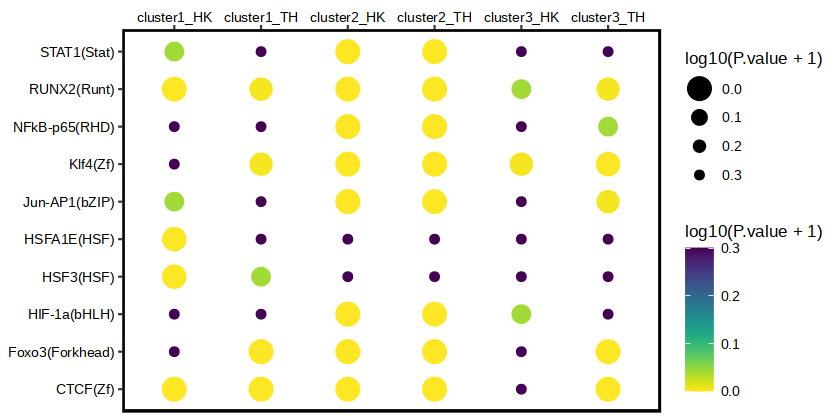

In [1952]:
options(repr.plot.width = 7,repr.plot.height = 3.5)
ggplot(homer_res2,aes(x = motif,y = group2,color = log10(P.value + 1),size = log10(P.value + 1))) + 
    geom_point() + 
    scale_size_continuous(range = c(6,2)) +
    scale_y_discrete(position = "right") +
    viridis::scale_color_viridis(option = "D",begin = 1,end = 0) +
    theme_classic(base_size = 10) + 
    labs(y = NULL ,x = NULL) +
    theme(axis.text.y = element_text(color = "black"),
          #legend.key.size = unit(2, 'mm'),
          axis.text.x = element_text(angle = 0,color = "black",hjust = 0.5),
          panel.border = element_rect(color = "black",linewidth = 1,fill = NA),
          axis.line = element_blank()) + 
    coord_flip()

In [2230]:
a <- reshape2::dcast(data = homer_res2[,c(4,6,7)],motif ~ group2,value.var = "P.value")
a <- a %>% tibble::column_to_rownames(var = "motif")
a <- a[c(4,5,3,6,2,9,10,7,1,8),]
a <- apply(a,2,function(x) format(x, scientific = TRUE))

In [2150]:
library(gridExtra)
# 使用gpar来设置字体大小
table_theme <- ttheme_default(
  core = list(fg_params=list(fontsize=7)),  # 设置表格主体字体大小
  colhead = list(fg_params=list(fontsize=8)),  # 设置列标题字体大小
  rowhead = list(fg_params=list(fontsize=8))  # 设置行标题字体大小，如果你有的话
)

In [ ]:
a1 <- gridExtra::tableGrob(a,theme = table_theme)
ggsave("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/plot/Ten_motif_DataFrame.pdf",#scale = .5,
       a1, width = 15, height = 18, units = "cm")

In [ ]:
homer_res2_shape <- reshape2::dcast(data = homer_res2[,c(5,6,7)],motif ~ group2,value.var = "Log.P.value")
homer_res2_shape <- homer_res2_shape %>% tibble::column_to_rownames(var = "motif")

In [ ]:
pdf("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/plot/ten_motif_dot_plot.pdf",width = 7,height = 3.5)
options(repr.plot.width = 7,repr.plot.height = 3.5)
ggplot(homer_res2,aes(x = motif,y = group2,color = log10(P.value + 1),size = log10(P.value + 1))) + 
    geom_point() + 
    scale_size_continuous(range = c(6,2)) +
    scale_y_discrete(position = "right") +
    viridis::scale_color_viridis(option = "D",begin = 1,end = 0) +
    theme_classic(base_size = 10) + 
    labs(y = NULL ,x = NULL) +
    theme(axis.text.y = element_text(color = "black"),
          axis.text.x = element_text(angle = 0,color = "black",hjust = 0.5),
          panel.border = element_rect(color = "black",linewidth = 1,fill = NA),
          axis.line = element_blank()) + 
    coord_flip()
dev.off()

In [ ]:
# 读取文件内容到字符向量
contents <- readr::read_lines("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/input/select_merge_10.motif")
# 找到“>”开头的行的索引
begin_indexes = grep("^>", contents)
# 再添加一个最后的索引，指代文件结束的位置
last_index = length(contents) + 1
begin_indexes = c(begin_indexes, last_index)
# 创建一个列表来存储数据框
dataframe_list = list()

In [ ]:
# 循环遍历所有的部分
for (i in 1:(length(begin_indexes) - 1)) {
  begin = begin_indexes[i]
  end = begin_indexes[i + 1] - 1  # 最后一行是下一个部分的开头，所以我们要 - 1
  segment = contents[(begin + 1) :end]
  name = strsplit(contents[begin],split = "\t")[[1]][2]
    
  # 把部分内容转成数据框并添加到列表
  df = do.call(rbind,strsplit(segment,split = "\t")) %>% as.data.frame 
  colnames(df) <- c("A","C","G","T")  
  dataframe_list[[name]] = apply(df,2,as.numeric)
}
names(dataframe_list) <- stringr::str_split(names(dataframe_list),pattern = "/",simplify = T)[,1]

In [ ]:
motif_logo_list <- list()
for(i in seq_along(dataframe_list)){
    motif_logo_list[[i]] <- ggseqlogo::ggseqlogo( t(dataframe_list[[i]]),method="prob") + 
        ggtitle(names(dataframe_list)[i] ) + 
        theme(plot.title = element_text(hjust = .5))
}

In [ ]:
options(repr.plot.width = 10,repr.plot.height = 8)
patchwork::wrap_plots(motif_logo_list,nrow = 4)

In [ ]:
pdf("/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/plot/Ten_motif_logo.pdf",width = 10,height = 8)
patchwork::wrap_plots(motif_logo_list,nrow = 4) 
dev.off()

### GO

In [ ]:
#GO_KEGG富集分析相关函数
enrichment_stat_go = function(bl,il) {
#  gos <- gene_go2
#  go_des <- go_des
  gos.bl <- gos[gos$gene %in% bl,]
  gos.il <- gos[gos$gene %in% il,]
  gos.bl.stat <- gos.bl %>% group_by(GO) %>% dplyr::summarise(GeneNumber=n()) %>% ungroup
  gos.il.stat <- gos.il %>% group_by(GO) %>% dplyr::summarise(GeneNumber=n()) %>% ungroup
  list.df <- gos.bl.stat %>% group_by(GO) %>% left_join(gos.il.stat,by="GO") %>% ungroup
  list.df[is.na(list.df)] <- 0
  names(list.df) <- c("GO","k","x")#k:bl x:il
  list.df$m = as.numeric(length(unique(sort(gos.il$gene))))
  list.df$n = as.numeric(length(unique(sort(gos.bl$gene))))-list.df$k
  list.df$Pvalue <- apply(list.df[,-1],1,FUN=function(x) {phyper(x[2]-1,x[1],x[4],x[3],lower.tail=F)})
  # if (id == "go"){
  #   list <- list[list$class == "biological_process" & list$k >= 10,]
  # }
  
  #list$p.adjust <- p.adjust(list$Pvalue,method="fdr",n=length(list$Pvalue))
  list.df <- list.df[order(list.df$Pvalue,decreasing=F),]
  list.df$fold = list.df$x*(list.df$n+list.df$k)/list.df$m/list.df$k ## should add fold enrichment value
  list.1 <- list.df %>% group_by(GO) %>% left_join(go_des,by="GO") %>% ungroup
  list.1 <- list.1[list.1$k>=10 & list.1$x>=3,]
  list.1$p.adjust <- p.adjust(list.1$Pvalue,method="fdr",n=length(list.1$Pvalue))
  list.1 <- list.1[list.1$Pvalue < 0.05,]
  list.1
}

enrichment_stat_kegg = function(bl,il) {
#  keggs <- keggs
#  kegg_des <- kegg_des
  
  keggs.bl <- keggs[keggs$gene %in% bl,]
  keggs.il <- keggs[keggs$gene %in% il,]
  keggs.bl.stat <- keggs.bl %>% group_by(kegg) %>% dplyr::summarise(GeneNumber=n()) %>% ungroup
  keggs.il.stat <- keggs.il %>% group_by(kegg) %>% dplyr::summarise(GeneNumber=n()) %>% ungroup
  list.df <- keggs.bl.stat %>% group_by(kegg) %>% left_join(keggs.il.stat,by="kegg") %>% ungroup
  list.df[is.na(list.df)]<-0
  names(list.df) <- c("kegg","k","x")
  list.df$m = as.numeric(length(unique(sort(keggs.il$gene))))
  list.df$n = as.numeric(length(unique(sort(keggs.bl$gene))))-list.df$k
  list.df$Pvalue <- apply(list.df[,-1],1,FUN=function(x) {phyper(x[2]-1,x[1],x[4],x[3],lower.tail=F)})
  # if (id == "kegg"){
  #   list <- list[list$class == "biological_process" & list$k >= 10,]
  # }
  
  #list.df$p.adjust <- p.adjust(list.df$Pvalue,method="fdr",n=length(list.df$Pvalue))
  list.df <- list.df[order(list.df$Pvalue,decreasing=F),]
  list.df$fold = list.df$x*(list.df$n+list.df$k)/list.df$m/list.df$k ## should add fold enrichment value
  list.1 <- list.df %>% group_by(kegg) %>% left_join(kegg_des,by="kegg") %>% ungroup
  list.1 <- list.1[list.1$k>=10 & list.1$x>=2,]
  list.1$p.adjust <- p.adjust(list.1$Pvalue,method="fdr",n=length(list.1$Pvalue))
  list.1 <- list.1[list.1$Pvalue < 0.05,]
  list.1
}

In [ ]:
load("/home/minghao/database/KEGG_KO_database/02_niletilapia/01_enrichment_gos_keggs/go_info.RData")
load("/home/minghao/database/KEGG_KO_database/02_niletilapia/01_enrichment_gos_keggs/kegg_info.RData")

In [ ]:
lapply(split(heatmap_gene2_cluster,heatmap_gene2_cluster$cluster),function(x){
    GO_res <- enrichment_stat_go(bl = rownames(BulkRNA_df),il = x$gene) %>% filter(p.adjust < 0.05)
    
    gos2 <- gos %>% group_by(gene) %>% left_join(unique(geneID_name),by = "gene",relationship = "many-to-many") %>% ungroup #gos的gene匹配基因名
    
    GO_gene <- gos2[gos2$gene %in% x$gene,] %>% group_by(GO) %>% summarise(gene = paste(gene,collapse = "/"),
                                                                      Gene.name = paste(Gene.name,collapse = "/"),
                                                                      eggnog_Preferred_name = paste(eggnog_Preferred_name,collapse = "/")
                                                                     ) %>% ungroup
    
    GO_res2 <- GO_res %>% left_join(GO_gene,by = "GO")
    
    return(GO_res2)
}) -> sub_heatmap_GO

In [ ]:
sub_heatmap_GO2 <- lapply(sub_heatmap_GO,function(x) x[,-11])

In [ ]:
openxlsx::write.xlsx(sub_heatmap_GO2,#sep = "\t",row.names = F,quote = F,
                     "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/RNA&ATAC_output/20240309_Fig2_subset_heatmap_gene_GO.xlsx")

In [ ]:
lapply(split(heatmap_gene2_cluster,heatmap_gene2_cluster$cluster),function(x){
    KEGG_res <- enrichment_stat_kegg(bl = rownames(BulkRNA_df),il = x$gene) %>% filter(p.adjust < 0.05)
    
    keggs2 <- keggs %>% group_by(gene) %>% left_join(unique(geneID_name),by = "gene",relationship = "many-to-many") %>% ungroup #keggs的gene匹配基因名
    
    KEGG_gene <- keggs2[keggs2$gene %in% x$gene,] %>% group_by(kegg) %>% summarise(gene = paste(gene,collapse = "/"),
                                                                      Gene.name = paste(Gene.name,collapse = "/"),
                                                                      eggnog_Preferred_name = paste(eggnog_Preferred_name,collapse = "/")
                                                                     ) %>% ungroup
    
    KEGG_res2 <- KEGG_res %>% left_join(KEGG_gene,by = "kegg")
    
    return(KEGG_res2)
}) -> sub_heatmap_KEGG

In [ ]:
sub_heatmap_KEGG2 <- lapply(sub_heatmap_KEGG,function(x) x[,-10])

In [ ]:
openxlsx::write.xlsx(sub_heatmap_KEGG2,
                     "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/output/RNA&ATAC_output/20240309_Fig2_subset_heatmap_gene_KEGG.xlsx")

In [ ]:
select_keggs <- c('ko04068',
'ko04140',
'ko04668',
'ko04931',
'ko04216',
'ko04657',
'ko04066',
'ko04010',
'ko04210',
'ko04919',
'ko04115')
temp <- sub_heatmap_KEGG[[2]][sub_heatmap_KEGG[[2]]$kegg %in% select_keggs,]

In [ ]:
temp %>% 
    mutate(gene.x = stringr::str_split(gene,pattern = "/")) %>% 
    tidyr::unnest(gene.x) %>% dplyr::select(1,13,8) -> temp

In [ ]:
merge_10_motif_result4 <- merge_10_motif_result3 %>% 
    inner_join(temp,by = c("RNA_gene" = "gene.x"),relationship = "many-to-many") %>% 
    distinct()

In [ ]:
merge_10_motif_result4$test <- NULL

In [ ]:
openxlsx::write.xlsx(merge_10_motif_result4,
                     "/home/minghao/workbase/16_Tilapia_Cold_BulkRNA-ATAC_jiaohe/Motif_Enrich/output/select_KEGG_gene_motif.xlsx")

*select related pathway*

In [ ]:
df <- read.delim("kegg.xls",header = T) #从merge_10_motif_result4中选取要展示的通路进行画图

In [ ]:
ggplot(df, aes(Description,p.adjust)) + 
    geom_bar(stat = 'identity', aes(fill = fold), width = 0.8, position = "stack") +
    coord_flip() +
    scale_x_discrete(labels = rev(df$Description)) +
    xlab("KEGG Term") + ylab("-log10 FDR") +
    theme_classic() +
    scale_fill_gradientn(colors = c("#440757", "#463478", "#3B5D8B", "#2B8E8B", "#60BE6A", "#E8E331")) +
    labs(fill = "log2(FE)") +
    theme(panel.background = element_rect(fill = "white"),
        axis.text.y = element_blank()) +
    geom_text(aes(y=.1,label = Description), hjust = 0, size = 4,color = "white")